# 第6章 与学习相关的技巧(20210219-20210221)

- 参数的更新方法，除了SGD之外，还有Momentum、AdaGrad、Adam等方法。
- 权重初始值的赋值方法对进行正确的学习非常重要。
- 作为权重初始值，Xavier方法、He初始值等比较有效。
- 通过使用Batch Normalization，可以加速学习，并且对初始值变得健壮。
- 抑制过拟合的正则化技术有Dropout、权值衰减等。
- 逐渐减小“好值”存在的范围是搜索超参数的一个有效方法。

神经网络的学习的目的是找到是损失函数的值尽可能小的参数，这是寻找最优参数的问题，解决这个问题的过程称为最优化。

- SGD

为了找到最优参数，我们使用参数的梯度，沿梯度方向更新参数，并重复这个步骤多次，从而逐渐靠近最优参数，这个过程称为随机梯度下降法（stochastic gradient deent），简称SGD。

$$W \leftarrow W - \eta \frac{\partial L}{\partial W}\tag{6.1}$$

SGD简单容易实现，但是解决某些问题可能没有效率，由于梯度方向不一定指向最小值的方向，搜素路径的效率可能会很低。

- Momentum

$$v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W}\tag{6.2}$$
$$W \leftarrow W + v \tag{6.3}$$

这里v对应物理上的速度，式（6.2）表示物体在梯度方向上受力，在这个力的作用下，物体速度增加这一物理法则。
虽然x轴方向上受的力很小，但是一直在同一方向受力，所以朝同一方向会有一定的加速，反过来y轴方向上的力会相互抵消，所以y轴方向上的速度不稳定。
和SGD相比，可以更快朝x轴方向靠近，减弱“之”字形的变动程度。

- AdaGrad

在关于学习率的技巧中，有一种称为学习率衰减的方法，即随着学习的进行，学习率逐渐减小。AdaGrad进一步发展了这个想法，针对一个一个的参数，赋予其“定制”的值。

$$h \leftarrow h + \frac{\partial L}{\partial W} \bigodot \frac{\partial L}{\partial W} \tag{6.4}$$
$$W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W} \tag{6.5}$$

参数的元素中变动较大的元素的学习率将变小。可以按参数的元素进行学习率衰减，使变动大的参数的学习率逐渐减小。

- Adam

Adam融合了Momentum和AdaGrad的方法，通过组合前面两个方法的优点，有望实现参数空间的高效搜索。此外，进行超参数的偏置校正也是Adam的特征。

In [1]:
# %load optimizer.py
import numpy as np

class SGD:

    """随机梯度下降法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


- 基于MNIST数据集的更新方法的比较

===========iteration:0===========
SGD:2.4402944807815796
Momentum:2.462989491140247
AdaGrad:2.02201014216181
Adam:2.269284471816192
===========iteration:100===========
SGD:1.373038854092859
Momentum:0.2477996711156233
AdaGrad:0.15963544098134264
Adam:0.2466630996040219
===========iteration:200===========
SGD:0.7005947326404454
Momentum:0.3456596422058166
AdaGrad:0.11063145924529358
Adam:0.2256375645150815
===========iteration:300===========
SGD:0.3645327018799957
Momentum:0.1674690719620554
AdaGrad:0.05546863990698726
Adam:0.14130595863800732
===========iteration:400===========
SGD:0.2659422481446669
Momentum:0.11342883616773075
AdaGrad:0.049412225638416726
Adam:0.13342009683886322
===========iteration:500===========
SGD:0.33144548148811875
Momentum:0.14881720716215557
AdaGrad:0.045792214533212666
Adam:0.05090789594171752
===========iteration:600===========
SGD:0.3258594221563284
Momentum:0.1488634987265809
AdaGrad:0.04079967025023283
Adam:0.05809487972388528
===========iteration:700==

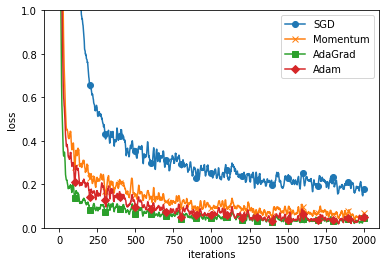

In [2]:
# %load optimizer_compare_mnist.py
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2001


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

这个实验以一个5层神经网络为对象，其中每层有100个神经元，激活函数使用的RELU

一般而言，与SGD相比，其他3种方法可以学习地更快，有时最终的识别精度也更高

## 6.2 权重的初始值 

**权值衰减**是一种以减小权重参数的值为目的进行学习的方法，通过减小权重参数的值来抑制过拟合的发生。为了减小权重参数的值，一开始就将初始值设为较小的值。

- 隐藏层的激活值的分布

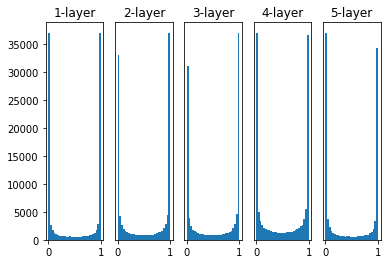

In [3]:
# %load weight_init_activation_histogram.py
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

这里使用sigmoid函数，随着输出不断靠近0（或1），它的导数的值逐渐接近0，因此偏向0和1的数据分布会造成反向传播中梯度的值不断变小，最后消失，这个问题称为**梯度消失**

- 将权重的标准差设为0.01

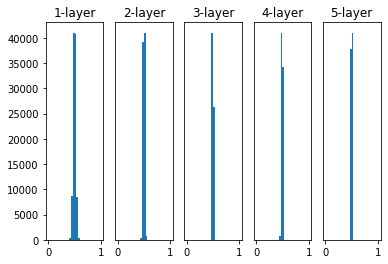

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

这次激活值集中在0.5附近，不会有梯度消失问题，但是激活值的分布有偏向，说明在表现力上会有很大问题。

如果多个神经元的输出都几乎相同，那么它们就没有存在的意义了。

- 使用Xavier初始值

在一般的深度学习框架中，Xavier初始值已经作为标准使用。

xavier初始值:如果前一层的节点数为n，则初始值使用标准差为$1/\sqrt{n}$的分布。

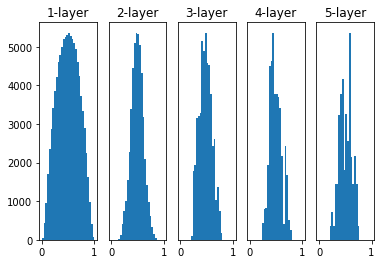

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

因为各层间传递的数据有适当广度，所以sigmoid函数的表现力步受限制，有望进行高效地学习。

上图的分布后面的层的分布呈现歪斜的形状，如果使用tanh函数代替sigmoid函数，这个稍微歪斜的问题就能得到改善

- Xavier初始值，使用tanh激活函数

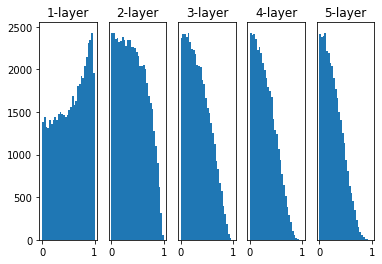

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    # z = sigmoid(a)
    # z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Xavier初始值是以激活函数是线性函数为前提而推倒出来的。因为sigmoid和tanh函数左右对称，在中央附近可以视为线性函数，所以适合使用Xavier初始值。

当使用ReLU函数作为激活函数时，一般推荐使用ReLU专用的初始值，也称为“He初始值”

- 使用ReLU激活函数

(1) std = 0.01

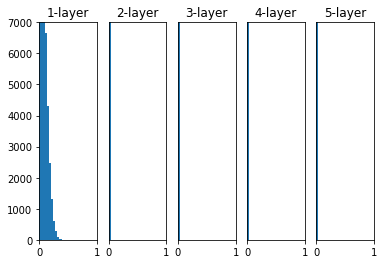

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

(2) Xavier初始值

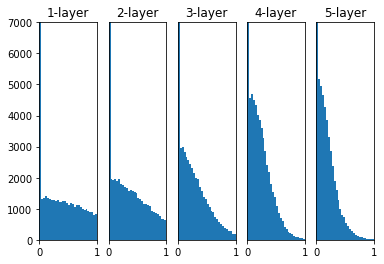

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

(3) He初始值

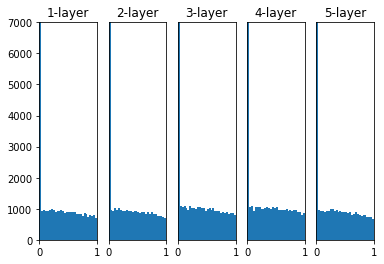

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

当激活函数使用ReLU时，权重初始值使用He初始值，当激活函数是sigmoid或tanh等S型曲线函数时，初始值使用Xavier初始值，这是当前的最佳实践。

- 基于MNIST数据集的权重初始值的比较

===========iteration:0===========
std=0.01:2.3025280783613766
Xavier:2.30368253083254
He:2.351298646635714
===========iteration:100===========
std=0.01:2.302398073031908
Xavier:2.23581677172528
He:1.587312767043855
===========iteration:200===========
std=0.01:2.3024285531759623
Xavier:2.1111782326714925
He:0.8498842556477271
===========iteration:300===========
std=0.01:2.3020373915799546
Xavier:1.7556902787726232
He:0.6037665083269886
===========iteration:400===========
std=0.01:2.302593915257798
Xavier:1.10659572223004
He:0.45005285632612
===========iteration:500===========
std=0.01:2.3032381542980183
Xavier:0.752137765316838
He:0.42811561470010473
===========iteration:600===========
std=0.01:2.3015649629175963
Xavier:0.5452358017529807
He:0.2755838018418411
===========iteration:700===========
std=0.01:2.305210525969872
Xavier:0.5190397878116046
He:0.2896047144781821
===========iteration:800===========
std=0.01:2.3009508522037243
Xavier:0.45495130243952475
He:0.26806826944385326
=====

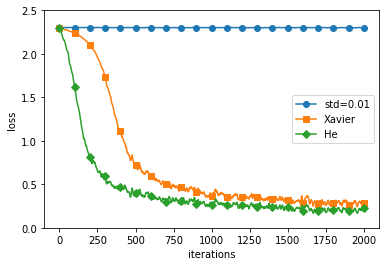

In [10]:
# %load weight_init_compare.py
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2001


# 1:进行实验的设置==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()

plt.show()

## 6.3 Batch Normalization 

Batch Norm的思路是调整各层的激活值的分布使其拥有适当的广度，以进行学习的mini-batch为单位，按mini-batch进行正规化。具体而言，就是使数据分布均值为0，方差为1的正规化。

Batch Norm有以下优点：
- 可以使学习快速进行
- 不那么依赖初始值
- 抑制过拟合

- Batch Normalization的评估

In [29]:
# %load batch_norm_test.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 减少学习数据
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

============== 1/16 ==============
epoch:0 | 0.105 - 0.123


D:\datasets\Deep learning from scratch\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
D:\datasets\Deep learning from scratch\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:1 | 0.097 - 0.115
epoch:2 | 0.097 - 0.1
epoch:3 | 0.097 - 0.123
epoch:4 | 0.097 - 0.142
epoch:5 | 0.097 - 0.176
epoch:6 | 0.097 - 0.176
epoch:7 | 0.097 - 0.191
epoch:8 | 0.097 - 0.202
epoch:9 | 0.097 - 0.214
epoch:10 | 0.097 - 0.244
epoch:11 | 0.097 - 0.252
epoch:12 | 0.097 - 0.273
epoch:13 | 0.097 - 0.296
epoch:14 | 0.097 - 0.317
epoch:15 | 0.097 - 0.34
epoch:16 | 0.097 - 0.35
epoch:17 | 0.097 - 0.375
epoch:18 | 0.097 - 0.403
epoch:19 | 0.097 - 0.413
============== 2/16 ==============
epoch:0 | 0.097 - 0.061
epoch:1 | 0.097 - 0.088


D:\datasets\Deep learning from scratch\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
D:\datasets\Deep learning from scratch\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:2 | 0.097 - 0.118
epoch:3 | 0.097 - 0.148
epoch:4 | 0.097 - 0.17
epoch:5 | 0.097 - 0.203
epoch:6 | 0.097 - 0.229
epoch:7 | 0.097 - 0.259
epoch:8 | 0.097 - 0.271
epoch:9 | 0.097 - 0.298
epoch:10 | 0.097 - 0.322
epoch:11 | 0.097 - 0.344
epoch:12 | 0.097 - 0.365
epoch:13 | 0.097 - 0.39
epoch:14 | 0.097 - 0.401
epoch:15 | 0.097 - 0.434
epoch:16 | 0.097 - 0.442
epoch:17 | 0.097 - 0.47
epoch:18 | 0.097 - 0.483
epoch:19 | 0.097 - 0.494
============== 3/16 ==============
epoch:0 | 0.129 - 0.076
epoch:1 | 0.362 - 0.1
epoch:2 | 0.513 - 0.14
epoch:3 | 0.625 - 0.174
epoch:4 | 0.661 - 0.21
epoch:5 | 0.732 - 0.25
epoch:6 | 0.76 - 0.276
epoch:7 | 0.811 - 0.326
epoch:8 | 0.834 - 0.358
epoch:9 | 0.859 - 0.39
epoch:10 | 0.884 - 0.433
epoch:11 | 0.901 - 0.448
epoch:12 | 0.907 - 0.475
epoch:13 | 0.927 - 0.508
epoch:14 | 0.939 - 0.539
epoch:15 | 0.948 - 0.567
epoch:16 | 0.959 - 0.584
epoch:17 | 0.965 - 0.609
epoch:18 | 0.97 - 0.627
epoch:19 | 0.978 - 0.647
============== 4/16 ==============
epoch:0 |

<IPython.core.display.Javascript object>


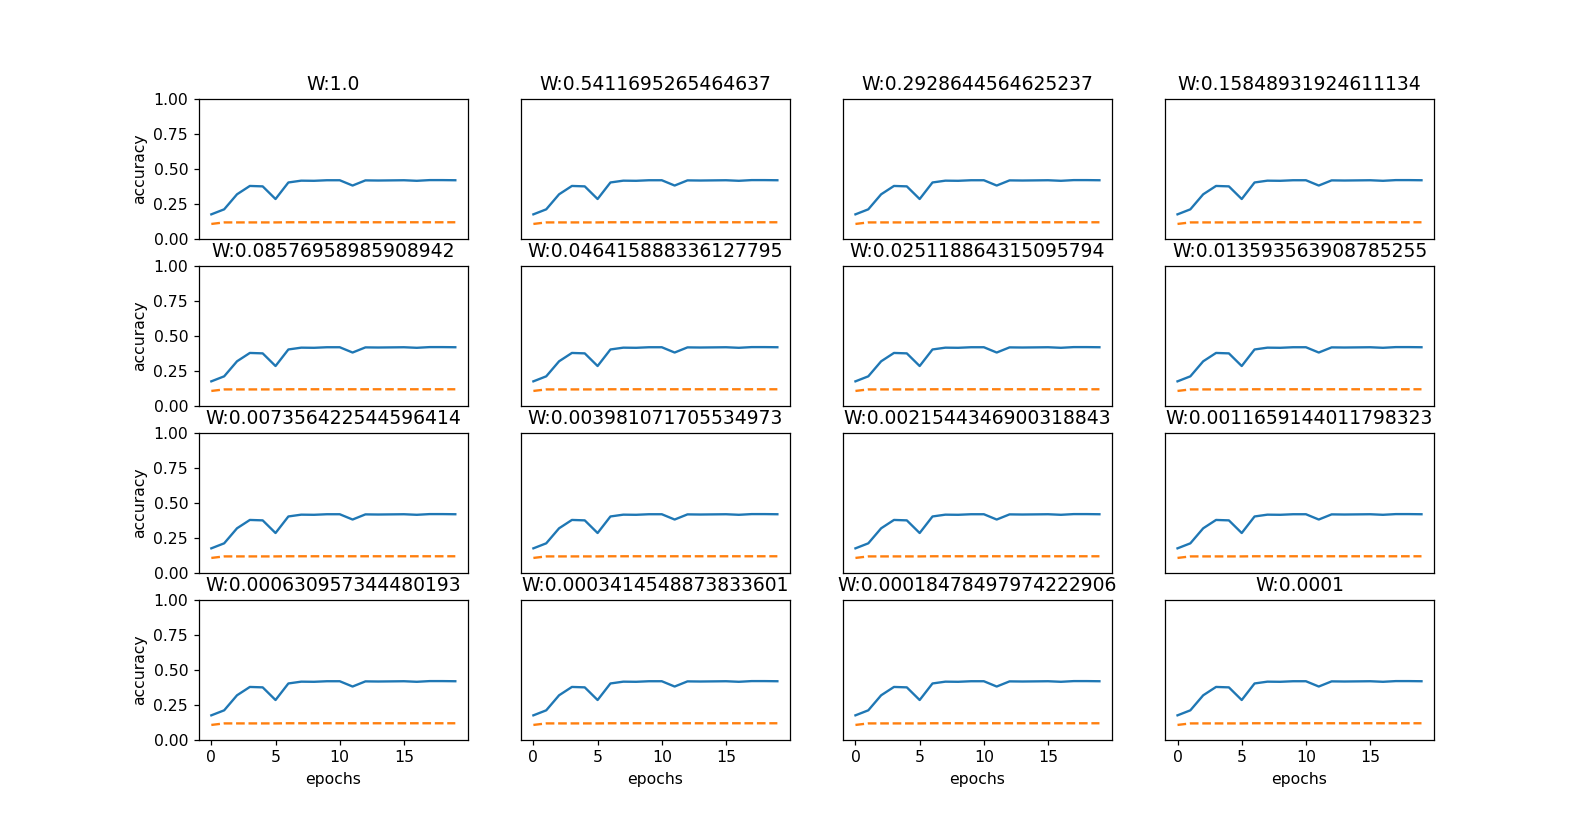

In [32]:
# 3.绘制图形==========              
for i, w in enumerate(weight_scale_list):  
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    
plt.show()

## 6.4 正则化 

发生过拟合的主要原因有两个：模型拥有大量参数、表现力强；训练数据少。

In [33]:
# %load overfit_weight_decay.py
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（权值衰减）的设定 =======================
#weight_decay_lambda = 0 # 不使用权值衰减的情况
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.13333333333333333, test acc:0.151
epoch:1, train acc:0.16, test acc:0.1668
epoch:2, train acc:0.17, test acc:0.1709
epoch:3, train acc:0.20333333333333334, test acc:0.1708
epoch:4, train acc:0.20333333333333334, test acc:0.1754
epoch:5, train acc:0.22333333333333333, test acc:0.1826
epoch:6, train acc:0.24666666666666667, test acc:0.1907
epoch:7, train acc:0.26, test acc:0.195
epoch:8, train acc:0.24666666666666667, test acc:0.1982
epoch:9, train acc:0.27666666666666667, test acc:0.2066
epoch:10, train acc:0.29, test acc:0.211
epoch:11, train acc:0.31333333333333335, test acc:0.2194
epoch:12, train acc:0.32, test acc:0.2228
epoch:13, train acc:0.33, test acc:0.2299
epoch:14, train acc:0.3333333333333333, test acc:0.2329
epoch:15, train acc:0.35333333333333333, test acc:0.2409
epoch:16, train acc:0.37, test acc:0.2447
epoch:17, train acc:0.3566666666666667, test acc:0.2431
epoch:18, train acc:0.37, test acc:0.2472
epoch:19, train acc:0.41333333333333333, test acc:0.

<IPython.core.display.Javascript object>


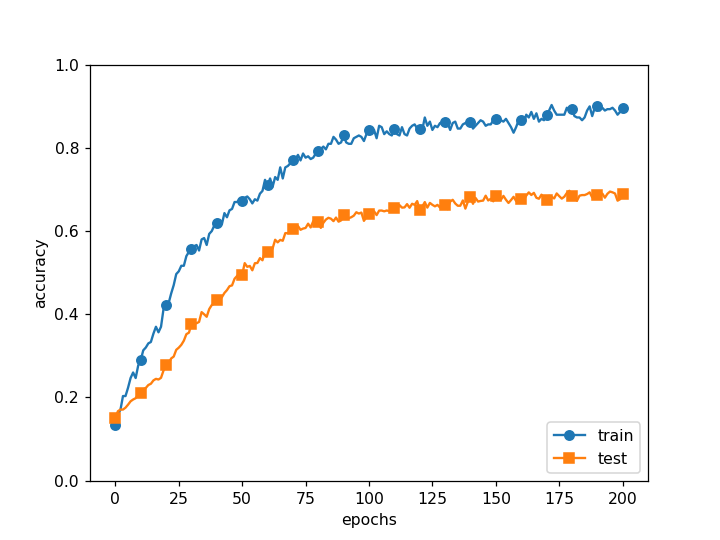

In [34]:
# 3.绘制图形==========
# 使用了权值衰减的训练数据和测试数据识别精度的变化
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

权值衰减是一直以来经常被使用抑制过拟合的一种方法，该方法通过在学习过程中对大的权重进行惩罚，来抑制过拟合。

如果将权重记为W，L2范数的权值衰减就是$\frac{1}{2}\lambda W^2$，然后将这个$\frac{1}{2}\lambda W^2$加到损失函数上。这里$\lambda$是控制正则化强度的超参数，$\lambda$设置地越大，对大的权重施加的惩罚就越重。

### 6.4.3 Dropout 

如果网络的模型变得很复杂，只用权值衰减就难易应对了。在这种情况下，我们经常会用到Dropout方法。

Dropout是一种在学习的过程中随机删除神经元的方法。

train loss:2.305555909469356
=== epoch:1, train acc:0.06666666666666667, test acc:0.0871 ===
train loss:2.302513497468379
train loss:2.305347622344429
train loss:2.310070886755455
=== epoch:2, train acc:0.07333333333333333, test acc:0.0882 ===
train loss:2.3217788102213657
train loss:2.304196739220415
train loss:2.3126850837166124
=== epoch:3, train acc:0.08666666666666667, test acc:0.0893 ===
train loss:2.312868762738183
train loss:2.3063763259990875
train loss:2.3152476848188437
=== epoch:4, train acc:0.09333333333333334, test acc:0.0904 ===
train loss:2.2944607726614366
train loss:2.2928655284751374
train loss:2.310449057359132
=== epoch:5, train acc:0.09333333333333334, test acc:0.0929 ===
train loss:2.2977405253399583
train loss:2.2922136599615976
train loss:2.3000939196919314
=== epoch:6, train acc:0.10666666666666667, test acc:0.093 ===
train loss:2.2946389882887583
train loss:2.300953598161889
train loss:2.3064364321244146
=== epoch:7, train acc:0.10333333333333333, test acc:0.

<IPython.core.display.Javascript object>


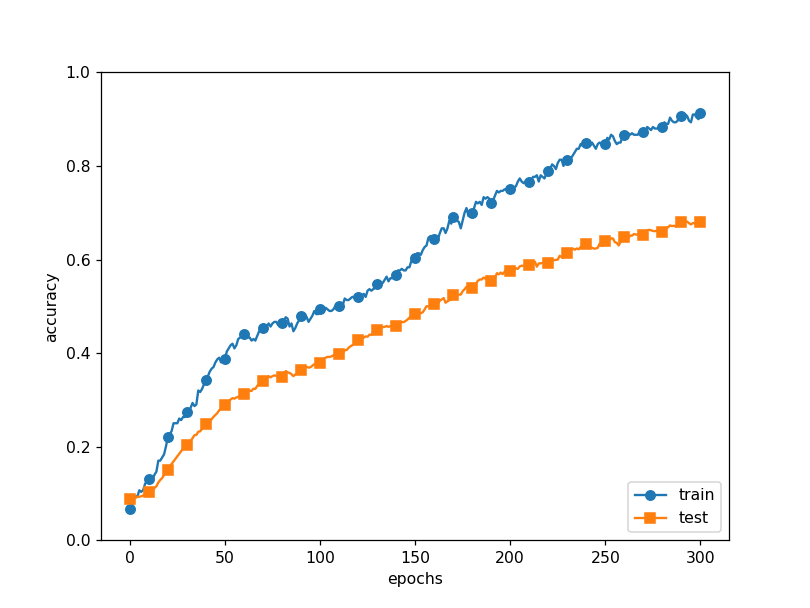

In [37]:
# %load overfit_dropout.py
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# 设定是否使用Dropuout，以及比例 ========================
use_dropout = True  # 不使用Dropout的情况下为False
dropout_ratio = 0.15
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.5 超参数的验证 

神经网络中的超参数指神经元数量、batch大小、参数更新时的学习率或权值衰减等。

训练数据用于参数（权重和偏置）的学习，验证数据用于超参数的性能的评估。为了确认泛化能力，最后使用测试数据。

超参数最优化的过程：

- 步骤0：设定超参数的范围
- 步骤1：从设定的超参数的范围内随机采样
- 步骤2：使用采样的超参数的值进行学习，通过验证数据评估识别精度（将epoch设置地很小）
- 步骤3：重复步骤1和2（100次等），根据识别精度结果，缩小超参数的范围

- 使用MNIST数据集进行超参数最优化

val acc:0.09 | lr:8.557741659781391e-05, weight decay:7.647684649087484e-05
val acc:0.05 | lr:1.104392268146882e-05, weight decay:1.1419331229790861e-05
val acc:0.13 | lr:1.3553217224575725e-05, weight decay:4.614247547757898e-07
val acc:0.07 | lr:5.1057203930638214e-05, weight decay:7.915002982920435e-05
val acc:0.08 | lr:0.0007523579821466738, weight decay:3.3706836577014706e-07
val acc:0.12 | lr:2.5816116512574946e-06, weight decay:1.8674791434405746e-06
val acc:0.13 | lr:4.91344103238037e-06, weight decay:6.79059230951366e-05
val acc:0.19 | lr:0.0015692934124114971, weight decay:1.3951150193604452e-05
val acc:0.1 | lr:0.0001400020435614543, weight decay:1.9956958765732728e-08
val acc:0.69 | lr:0.007493456788709791, weight decay:4.931826457638445e-07
val acc:0.76 | lr:0.006528865136863075, weight decay:6.235961299951365e-05
val acc:0.83 | lr:0.009834263902338564, weight decay:4.900880900986797e-07
val acc:0.11 | lr:0.00015937356960708048, weight decay:8.988175153578558e-07
val acc:0

<IPython.core.display.Javascript object>


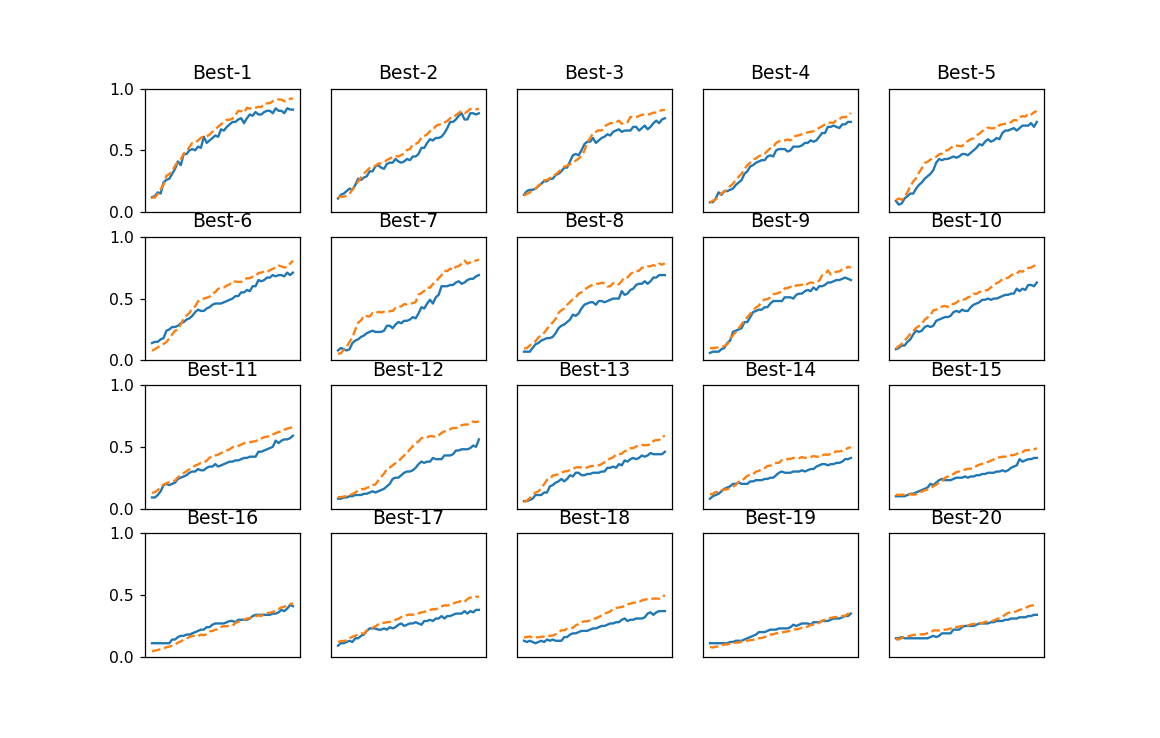

Best-2(val acc:0.8) | lr:0.00638547850549569, weight decay:1.566085574797139e-06
Best-3(val acc:0.76) | lr:0.006528865136863075, weight decay:6.235961299951365e-05
Best-4(val acc:0.73) | lr:0.005255984318214297, weight decay:6.294162438753364e-08
Best-5(val acc:0.73) | lr:0.005429915259915097, weight decay:1.4535997425348716e-08
Best-6(val acc:0.71) | lr:0.005927644571012314, weight decay:2.6372079930535963e-05
Best-7(val acc:0.69) | lr:0.007493456788709791, weight decay:4.931826457638445e-07
Best-8(val acc:0.69) | lr:0.005936326836729521, weight decay:1.24738040955042e-08
Best-9(val acc:0.65) | lr:0.005536056879959289, weight decay:2.0085178588983752e-05
Best-10(val acc:0.63) | lr:0.005360876452396417, weight decay:1.2767927422903641e-07
Best-11(val acc:0.59) | lr:0.004611108724173576, weight decay:7.06264607493606e-05
Best-12(val acc:0.56) | lr:0.003919282119264875, weight decay:4.7341875572228384e-07
Best-13(val acc:0.46) | lr:0.00351617226916857, weight decay:4.955759660158626e-07


In [39]:
# %load hyperparameter_optimization.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了实现高速化，减少训练数据
x_train = x_train[:500]
t_train = t_train[:500]

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 超参数的随机搜索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 指定搜索的超参数的范围===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 绘制图形========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


- 参数的更新方法，除了SGD之外，还有Momentum、AdaGrad、Adam等方法。
- 权重初始值的赋值方法对进行正确的学习非常重要。
- 作为权重初始值，Xavier方法、He初始值等比较有效。
- 通过使用Batch Normalization，可以加速学习，并且对初始值变得健壮。
- 抑制过拟合的正则化技术有Dropout、权值衰减等。
- 逐渐减小“好值”存在的范围是搜索超参数的一个有效方法。